In [1]:
import torch
import pandas as pd
import numpy as np
import os
import tqdm
from torchsummary import summary
from matplotlib import pyplot as plt

In [2]:
torch.__version__

'1.7.1+cu110'

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [17]:
torch.cuda.get_device_name(0)

'Tesla T4'

### dataset

In [5]:
def create_datasets(batch_size):
    valid_size = 0.2
    
    # torch.FloatTensor로 변환
    train = pd.read_csv('./data/train.csv')
    test = pd.read_csv('./data/test.csv')
    
    train_data = torch.tensor(train.to_numpy()).float()
    test_data = torch.tensor(test.to_numpy()).float()
    
    # validation으로 사용할 training indices 얻기 
    num_train = len(train_data)
    indices = list(range(num_train))
    np.random.shuffle(indices)
    split = np.int(np.floor(valid_size * num_train)) # 0.2 비율만큼 val에 할당 
    train_idx, val_idx = indices[split:], indices[:split]
    
    val_data = train_data[val_idx]
    train_data = train_data[train_idx]
    
    # load traing data in batches 
    train_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=0
    )
    val_loader = torch.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        num_workers=0
    )
    test_loader = torch.utils.data.DataLoader(
        test_data,
        batch_size=batch_size,
        num_workers=0
    )
    
    return train_loader, test_loader, val_loader

### define network

In [6]:
from torch import nn

class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(32, 16),
            nn.BatchNorm1d(16),
            nn.ELU(),
            
            nn.Linear(16, 8),
            nn.BatchNorm1d(8),
            nn.ELU(),
            nn.Dropout(0.3),
            
            nn.Linear(8, 8),
            nn.BatchNorm1d(8),
            nn.GELU(),
            nn.Dropout(0.3),
            
            nn.Linear(8, 4)
        )
        
    def forward(self, x):
        logits = self.network(x)
        
        return logits

In [7]:
model = net().to(device)
print(model)

net(
  (network): Sequential(
    (0): Linear(in_features=32, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ELU(alpha=1.0)
    (3): Linear(in_features=16, out_features=8, bias=True)
    (4): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ELU(alpha=1.0)
    (6): Dropout(p=0.3, inplace=False)
    (7): Linear(in_features=8, out_features=8, bias=True)
    (8): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): GELU()
    (10): Dropout(p=0.3, inplace=False)
    (11): Linear(in_features=8, out_features=4, bias=True)
  )
)


In [8]:
summary(model, (32, ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 16]             528
       BatchNorm1d-2                   [-1, 16]              32
               ELU-3                   [-1, 16]               0
            Linear-4                    [-1, 8]             136
       BatchNorm1d-5                    [-1, 8]              16
               ELU-6                    [-1, 8]               0
           Dropout-7                    [-1, 8]               0
            Linear-8                    [-1, 8]              72
       BatchNorm1d-9                    [-1, 8]              16
             GELU-10                    [-1, 8]               0
          Dropout-11                    [-1, 8]               0
           Linear-12                    [-1, 4]              36
Total params: 836
Trainable params: 836
Non-trainable params: 0
---------------------------------------

### define Earlystopping

In [9]:
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        '''
        patience (int): val loss가 개선된 후 기다리는 기간. default: 7
        verbose (bool): True일 경우 각 val loss의 개선 사항 메시지 출력. default: False
        delta (float): 개선되었다고 인정되는 monitered quantity의 최소 변화. default: 0
        path (str): checkpoint 저장 경로. default: 'checkpoint.pt'
        '''
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.Inf
        self.delta = delta
        self.path = path
        
    def __call__(self, val_loss, model): 
        
        score = -val_loss 
        
        if self.best_score is None: 
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else: 
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0
            
    def save_checkpoint(self, val_loss, model):
        '''val_loss가 감소하면 save model'''
        if self.verbose:
            print(f'Val_loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Save model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

### train

In [10]:
def train_model(model, batch_size, patience, n_epochs):
    # train_loss track
    train_losses = []
    # val_loss track
    val_losses = []
    # epoch 당 average train_loss track
    avg_train_losses = []
    # epoch 당 average val_loss track
    avg_val_losses = []
    
    # early_stopping object의 초기화 
    early_stopping = EarlyStopping(patience = patience, verbose=True)
    
    for epoch in range(1, n_epochs + 1):
        # train the model 
        model.train() # prep model for training 
        for batch, datas in enumerate(train_loader, 1):
            data = datas[:, 1:33].to(device)
            target = datas[:, 33].to(device).to(torch.int64)
            
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: 입력된 값을 모델로 전달하여 예측 출력 계산
            output = model(data)
            
            # calculate the loss
            loss = loss_fn(output, target)
            # backward pass: 모델의 parameter와 관련된 loss의 gradient 계산
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            
            # record training loss
            train_losses.append(loss.item())
            
        # validate the model
        model.eval() # prep model for evaluation
        for datas in val_loader: 
            data = datas[:, 1:33].to(device)
            target = datas[:, 33].to(device).to(torch.int64)
            
            output = model(data)
            loss = loss_fn(output, target)
            
            val_losses.append(loss.item())
        
        # print 학습/검증 statistics
        # epoch 당 avg loss 계산 
        train_loss = np.average(train_losses)
        val_loss = np.average(val_losses)
        avg_train_losses.append(train_loss)
        avg_val_losses.append(val_loss)
        
        epoch_len = len(str(n_epochs))
        
        print_msg = (f'[{epoch:>{epoch_len}}/{n_epochs:>{epoch_len}}]' +
                     f'train_loss: {train_loss:.5f} ' + 
                     f'val_loss: {val_loss:.5f}')
        print(print_msg)
        
        # clear lists to track next epoch
        train_losses = []
        val_losses = []
        
        # early_stopping은 val loss가 감소하였는지 확인이 필요
        # 만약 감소하였을 경우 현재 model을 checkpoint로 만듦
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping")
            break
            
    # best model이 저장되어있는 last checkpoint load
    model.load_state_dict(torch.load('checkpoint.pt'))
    
    return model, avg_train_losses, avg_val_losses

In [11]:
learning_rate = 0.001
batch_size = 256
loss_fn = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
patience = 30
n_epochs = 500

train_loader, test_loader, val_loader = create_datasets(batch_size)

model, train_loss, val_loss = train_model(model, batch_size, patience, n_epochs)

<ipython-input-5-801abeefc61e>:15: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  split = np.int(np.floor(valid_size * num_train)) # 0.2 비율만큼 val에 할당


[  1/500]train_loss: 1.43149 val_loss: 1.39862
Val_loss decreased (inf --> 1.398620). Save model ...
[  2/500]train_loss: 1.42241 val_loss: 1.38717
Val_loss decreased (1.398620 --> 1.387170). Save model ...
[  3/500]train_loss: 1.41009 val_loss: 1.37213
Val_loss decreased (1.387170 --> 1.372127). Save model ...
[  4/500]train_loss: 1.39218 val_loss: 1.35781
Val_loss decreased (1.372127 --> 1.357815). Save model ...
[  5/500]train_loss: 1.38273 val_loss: 1.34598
Val_loss decreased (1.357815 --> 1.345976). Save model ...
[  6/500]train_loss: 1.39530 val_loss: 1.33697
Val_loss decreased (1.345976 --> 1.336972). Save model ...
[  7/500]train_loss: 1.36030 val_loss: 1.32985
Val_loss decreased (1.336972 --> 1.329851). Save model ...
[  8/500]train_loss: 1.35549 val_loss: 1.32455
Val_loss decreased (1.329851 --> 1.324550). Save model ...
[  9/500]train_loss: 1.35613 val_loss: 1.31919
Val_loss decreased (1.324550 --> 1.319194). Save model ...
[ 10/500]train_loss: 1.34175 val_loss: 1.31456
Val_

### result visualization

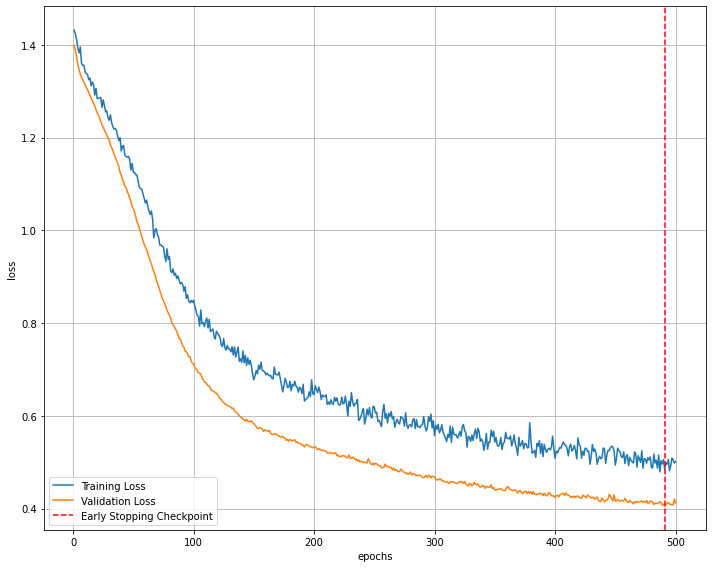

In [12]:
# 훈련이 진행되는 과정에 따라 loss를 시각화 
fig = plt.figure(figsize=(10,8))
plt.plot(range(1, len(train_loss)+1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss)+1), val_loss, label='Validation Loss')

# validation loss의 최저값 지점 찾기 
minposs = val_loss.index(min(val_loss)) + 1
plt.axvline(minposs, linestyle='--', color='r', label='Early Stopping Checkpoint')

plt.xlabel('epochs')
plt.ylabel('loss')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
fig.savefig('loss_plot.png', bbox_inches='tight')

In [13]:
# test loss 및 accuracy을 모니터링하기 위해 list 초기화 
test_loss = 0.0
class_correct = list(0. for i in range(4))
class_total = list(0. for i in range(4))

model.eval() # prep model for evaluation
for datas in val_loader: 
    if len(datas) != batch_size:
        break
    # forward pass: 입력을 모델로 전달하여 예측된 출력 계산 
    data = datas[:, 1:33].to(device)
    target = datas[:, 33].to(device).to(torch.int64)
    
    output = model(data)
    # calculate the loss 
    loss = loss_fn(output, target)
    # update test loss
    test_loss += loss.item() * data.size(0)
    # 출력된 확률을 예측된 클래스로 변환 
    _, pred = torch.max(output, 1)
    # 예측과 실제 라벨과 비교 
    correct = np.squeeze(pred.eq(target.data.view_as(pred)))
    # 각 object class에 대해 test accuracy 계산
    for i in range(batch_size):
        label = target[i].to('cpu').numpy()
        class_correct[label] += correct[i].item()
        class_total[label] += 1
        
# calculate and print avg test loss
test_loss = test_loss / len(val_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(4):
    if class_total[i] > 0: 
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            str(i), 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])
        ))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)
))

Test Loss: 0.407631

Test Accuracy of     0: 86% (382/441)
Test Accuracy of     1: 87% (382/438)
Test Accuracy of     2: 92% (418/450)
Test Accuracy of     3: 74% (344/463)

Test Accuracy (Overall): 85% (1526/1792)


### make submission

In [14]:
submission = pd.read_csv('./data/sample_submission.csv')

model.eval()

batch_index = 0

for i, data in enumerate(test_loader):
    data = data[:, 1:].to(device).float()
    outputs = model(data)
    batch_index = i * batch_size
    max_vals, max_indices = torch.max(outputs, 1)
    submission.iloc[batch_index:batch_index + batch_size, 1:] = max_indices.long().cpu().numpy()[:, np.newaxis]


In [15]:
submission

,id,target
0,1,0
1,2,0
2,3,0
3,4,1
4,5,2
...,...,...
9338,9339,1
9339,9340,1
9340,9341,2
9341,9342,0


In [16]:
submission.to_csv('pytorch.csv', index=False)